# COVID-19 Analysis UK

# Imports 

In [5]:
import requests                                  # Import libary for HTTP requests   
from typing import Iterable, Dict, Union, List   # This library is being used to take data from multiple pages
from json import dumps                           # Library for json files
from http import HTTPStatus                      # Library needed to check the status of the HTTP request
import pandas as pd                              # Library for pandas dataframes and plots
import matplotlib.pyplot as plt                  # Library for plots

## Open Data COVID-19 API

## Import Data

In [6]:
# For this function I used code from the documentation of the API
# URL: https://coronavirus.data.gov.uk/details/developers-guide/main-api
def get_API_data(filters: dict, structure: dict) -> list:
    """
    Send a specific query to the API and retrieves all the data provided 
    by the API that matches the query. Use all the related pages to get the data.

    :param filters: The filters to be passed to the query of type `dict`.
    :param structure: What information the query should return of type `dict`.
    :return: The data of type `list` returned from the API in json format.
    """
    
    # Define some datastructures objects which will be used to get data from all the pages
    StructureType = Dict[str, Union[dict, str]]
    FiltersType = Iterable[str]
    APIResponseType = Union[List[StructureType], str]
    
    # Main URL
    main_URL = 'https://api.coronavirus.data.gov.uk/v1/data?'  
    
    # Format filter values so that they can be accepted by the API
    filters_list = []  
    for key, value in filters.items():
        filter_string = str(key)+'='+str(value)
        filters_list.append(filter_string)

    # Create a dictionary which includes all the parameters of the query(filters+structure)    
    api_params = {
        "filters": str.join(";", filters_list),
        "structure": dumps(structure, separators=(",", ":"))
    }

    # Next we need to make sure that we get the data from all the pages.
    data = list()  # We initialize the list for our data
    page_number = 1  # We begin from page 1 and continue until we load all the pages

    while True:
        # Adding page number to query params
        api_params["page"] = page_number

        response = requests.get(main_URL, params=api_params, timeout=10)  # Send API request

        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f'Request failed: {response.text}')
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break

        # We add the data of the current page to the list and continue searching to the other pages.
        current_data = response.json()
        page_data: List[StructureType] = current_data['data']
        data.extend(page_data)

        # The "next" attribute in "pagination" will be `None`
        # when we reach the end.
        if current_data["pagination"]["next"] is None:
            break

        page_number += 1  # Increase the page counter

    return data  # Return the dataset

## Define Filters for API call

In [7]:
# For the cumulative vaccinations I used the variable cumPeopleVaccinatedCompleteByVaccinationDate since 
# as stated in the large group tutorial of Week 11 it leads to the same data. 
structure = {  # Set the variables that we need.
    "date": "date",
    "name": "areaName",
    "daily_cases": "newCasesBySpecimenDate",
    "cumulative_cases": "cumCasesBySpecimenDate",
    "daily_deaths": "newDeaths28DaysByPublishDate",
    "cumulative_deaths": "cumDeaths28DaysByPublishDate",
    "cumulative_vaccinated": "cumPeopleVaccinatedSecondDoseByVaccinationDate",
    "vaccination_age": "vaccinationsAgeDemographics"
}


filters_national = {  # Set the filter for the national level.
    "areaType": "nation"
}

filters_regional = {  # Set the filter for the regional level.
    "areaType": "region"
}

# Request data for the 2 lists 
results_json_national = get_API_data(filters_national, structure)
results_json_regional = get_API_data(filters_regional, structure)

## Shaping the COVID data into different dataframes

In [8]:
# Combine the 2 lists 
res = results_json_national + results_json_regional

In [9]:
# Convert list of dictionaries to dataframe 
covid_data = pd.DataFrame(res)

In [10]:
# Drop rows where name == 'England'
covid_data = covid_data.drop(covid_data[covid_data.name =='England'].index)

In [11]:
# Rename column name to area 
covid_data = covid_data.rename(columns={'name': 'area'})

In [12]:
# Convert date column to datetime type and check that the conversion has been performed correctly.
covid_data[["date"]] = covid_data[["date"]].apply(pd.to_datetime)

## Print Summary Statistics

In [13]:
# Display basic statistics for each numeric column in the dataframe.
covid_data.describe()

,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated
count,12142.000000,1.214100e+04,10179.000000,10192.000000,7.305000e+03
mean,1966.240735,7.983649e+05,15.675214,10891.951531,3.265775e+06
std,3174.869428,8.789385e+05,30.494623,6631.441390,2.010884e+06
min,0.000000,1.000000e+00,0.000000,1.000000,8.000000e+00
25%,231.000000,5.926000e+04,0.000000,5694.000000,1.806458e+06
50%,789.000000,4.424900e+05,5.000000,10131.500000,3.753121e+06
75%,2526.000000,1.326552e+06,17.000000,16131.500000,4.450727e+06
max,40221.000000,3.304811e+06,459.000000,27552.000000,7.070630e+06


 ## Fix Missing Values

In [14]:
# Display the percentage of missing values for each column as we want to see which variables are ready  
# for further analysis and for which variables we need to impute their missing values. 
# The way the missing data percentage is calculated is by dividing the total number of missing values
# in each column with the total number of rows in our dataset and then multiply by 100.
covid_data.isna().sum()/len(covid_data)*100

date                      0.000000
area                      0.000000
daily_cases               0.098733
cumulative_cases          0.106961
daily_deaths             16.249794
cumulative_deaths        16.142834
cumulative_vaccinated    39.896330
vaccination_age           0.000000
dtype: float64

In [15]:
# Impute missing values for variables: cumulative deaths, cumulative cases, cumulative vaccinated
# By taking the previous (chronologically) valid value for the same region.

# First we need to sort our values by the date column in descending order (most recent first)
covid_data = covid_data.sort_values(by='date', ascending=False)
covid_data = covid_data.reset_index(drop=True)

# Perform backwards fill in order to fill the misisng values with the last valid value of the same area if it exists
covid_data[['cumulative_deaths', 'cumulative_cases', 'cumulative_vaccinated']]= covid_data[['area', 'cumulative_deaths', 'cumulative_cases', 'cumulative_vaccinated']].groupby(['area']).bfill().sort_index()

In [16]:
# Drop the only the rows where the cummulative indexes have missing values
cols = ['cumulative_deaths', 'cumulative_cases', 'cumulative_vaccinated']
covid_data = covid_data.dropna(subset=cols)

## Feature Engineering

In [17]:
# Create the following variables:
# I used info from the following
# URL: https://stackoverflow.com/questions/53339021/python-pandas-calculate-moving-average-within-group
# Author: zipa
# daily_cases_roll_avg:  7-day rolling average of new daily cases in that area, including the current day.
# daily_deaths_roll_avg: 7-day rolling average of new daily deaths in that area, including the current day.

# First we sort our dataframe by date in ascending order so that the oldest date is first
covid_data = covid_data.sort_values(by='date', ascending=True)
covid_data = covid_data.reset_index(drop=True)  # Rest the index
# Then we create our variables
covid_data['daily_cases_roll_avg']  = covid_data.groupby('area')['daily_cases'].transform(lambda x: x.rolling(7).mean())
covid_data['daily_deaths_roll_avg'] = covid_data.groupby('area')['daily_deaths'].transform(lambda x: x.rolling(7).mean())

In [18]:
# Drop columns daily_cases, daily_deaths
covid_data = covid_data.drop(['daily_cases','daily_deaths'], axis=1)

In [19]:
# Copy columns: date, area, vaccination_age to a new dataframe named: covid_data_vaccinations
# Delete column: vaccination_age from original dataframe

# Create a deep copy of the original dataset using only the columns that we need.
covid_data_vaccinations = covid_data[['date', 'area', 'vaccination_age']].copy(deep=True)

# Drop column vaccination_age from covid_data dataframe
covid_data = covid_data.drop(['vaccination_age'], axis=1)

In [20]:
##### Logic: 1. For each row expand the list of dictionaries into a dataframe. 
#####        2. Append all of these dataframes of each row into a dataframe.
#####        3. Merge this dataframe with the covid_data_vaccinations
#####        4. Keep only the variables that we are interested in.

# Transform covid_data_vaccinations into a new expanded dataframe named: covid_data_vaccinations_wide
covid_data_vaccinations['index_column'] = covid_data_vaccinations.index  # Create the index column for the merging

columns_expanded = [ 
'age',
'VaccineRegisterPopulationByVaccinationDate'               ,
'cumPeopleVaccinatedCompleteByVaccinationDate'             ,
'newPeopleVaccinatedCompleteByVaccinationDate'             ,
'cumPeopleVaccinatedFirstDoseByVaccinationDate'            ,
'newPeopleVaccinatedFirstDoseByVaccinationDate'            ,
'cumPeopleVaccinatedSecondDoseByVaccinationDate'           ,
'newPeopleVaccinatedSecondDoseByVaccinationDate'           ,
'cumVaccinationFirstDoseUptakeByVaccinationDatePercentage' ,
'cumVaccinationCompleteCoverageByVaccinationDatePercentage',
'cumVaccinationSecondDoseUptakeByVaccinationDatePercentage',
'index_column'
]


#  Initialize the epxanded dataframe
expanded_dataset = pd.DataFrame(columns=columns_expanded)  # Initialiase a dataframe for the expanded info

############## Helper Function #################################
def convert_to_dataframe(list_of_dicts: list, row_index: int):
    """ Convert a list of dictionaries into a pandas dataframe. 
    
    :param list_of_dicts: The list of dictionaries that contains the values that we are interested in.
    :param row_index: The row index in order to merge the new info with the row in the original dataset.
    """
    global expanded_dataset
    if list_of_dicts is not None:          # Check if that row has a value for the specific variable.
        res = pd.DataFrame(list_of_dicts)  # Expand the list of dicts into a dataframe for the specific row.
        res['index_column'] = row_index    # Assign the row index so that we can merge with the original dataset.
        res= res[res.columns.intersection(columns_expanded)]  # Keep only the columns that we are interested in.
        expanded_dataset = expanded_dataset.append(res)  # Append dataframe to the collection of expanded dataframes for each row 
    else:  # If this row does not have a value for this variable not opperation will be performed
        pass
        
#################### END OF HELPER FUNCTION #########################

# Apply our helper function to the datarame and append rows to the epanded dataframe
covid_data_vaccinations.apply(lambda x: convert_to_dataframe(x.vaccination_age, x.index_column), axis=1)

# As a final step merge this dataset to our covid_data_vaccinations dataset 
covid_data_vaccinations_wide = pd.merge(left = covid_data_vaccinations , right = expanded_dataset, left_on = 'index_column', right_on ='index_column',  how='left')

# Drop the columns that we do not need
# Primary key of this table: date, area, age 
covid_data_vaccinations_wide = covid_data_vaccinations_wide.drop(['index_column','vaccination_age'], axis=1)

## Aggregating, plotting, and analysing

## Cumulative cases in London as they evolve through time.

<AxesSubplot:title={'center':'Cumulative cases in London as they evolve through time'}, xlabel='Date', ylabel='Cumulative cases (measured in milions)'>

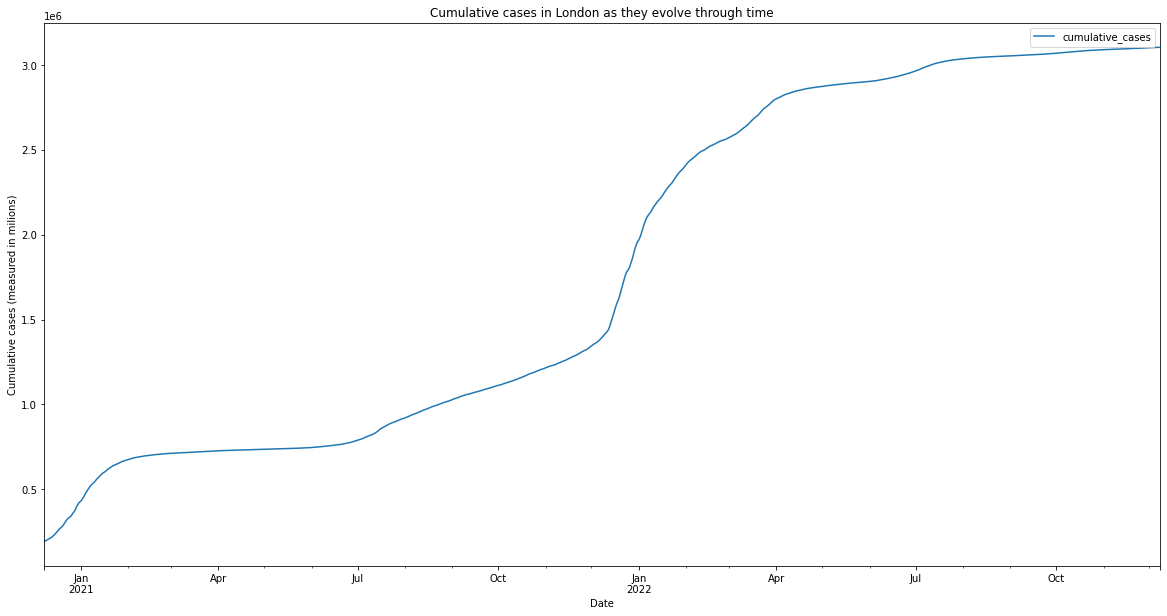

In [21]:
# Cumulative cases in London as they evolve through time.
# Dataset needed: covid_data

# 1. Aggregate the data 

London_data = covid_data[covid_data['area'] =='London'] # Keep only the rows that correspond to London
London_data = London_data[['date','cumulative_cases']]  # Keep the columns that we are interested in. 
London_data = London_data.set_index('date')             # Assign date column to inde.

# 2. Plot the data 
London_data.plot(figsize=(20, 10), title='Cumulative cases in London as they evolve through time',xlabel='Date', ylabel="Cumulative cases (measured in milions)")

# 3. My comment for the plot

# We oberve that the cumulative cases for London have an increasing patern until roughly April 2022.
# After April 2022 we can observe a flat/stable pattern.


## Evolution through time of cumulative cases summed over all areas.

<AxesSubplot:title={'center':'Evolution through time of cumulative cases summed over all areas'}, xlabel='Date', ylabel='Cumulative cases (measured in 10^7)'>

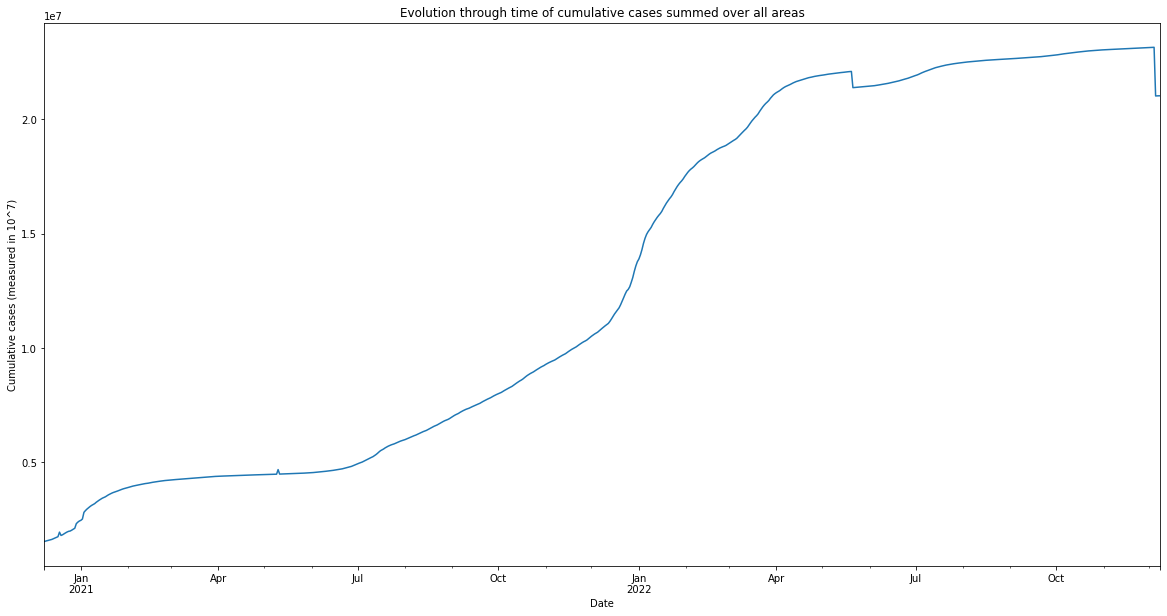

In [22]:
# Evolution through time of cumulative cases summed over all areas.
# Dataset needed: covid_data

# 1. Aggregate the data 
# For each date we sum the number of cases across the different areas.
cumulative_cases_over_all_areas = covid_data.groupby('date').sum()['cumulative_cases']

# 2. Plot the data 
cumulative_cases_over_all_areas.plot(figsize=(20, 10), title='Evolution through time of cumulative cases summed over all areas',xlabel='Date', ylabel="Cumulative cases (measured in 10^7)")

# 3. My comment for the plot

# We observe a similar pattern with the previous plot. After April 2022 we can observe a flat/stable pattern.

## Εvolution of cumulative cases of different areas over time.

area
East Midlands               AxesSubplot(0.125,0.2;0.775x0.68)
East of England             AxesSubplot(0.125,0.2;0.775x0.68)
London                      AxesSubplot(0.125,0.2;0.775x0.68)
North East                  AxesSubplot(0.125,0.2;0.775x0.68)
North West                  AxesSubplot(0.125,0.2;0.775x0.68)
Northern Ireland            AxesSubplot(0.125,0.2;0.775x0.68)
Scotland                    AxesSubplot(0.125,0.2;0.775x0.68)
South East                  AxesSubplot(0.125,0.2;0.775x0.68)
South West                  AxesSubplot(0.125,0.2;0.775x0.68)
Wales                       AxesSubplot(0.125,0.2;0.775x0.68)
West Midlands               AxesSubplot(0.125,0.2;0.775x0.68)
Yorkshire and The Humber    AxesSubplot(0.125,0.2;0.775x0.68)
Name: cumulative_cases, dtype: object

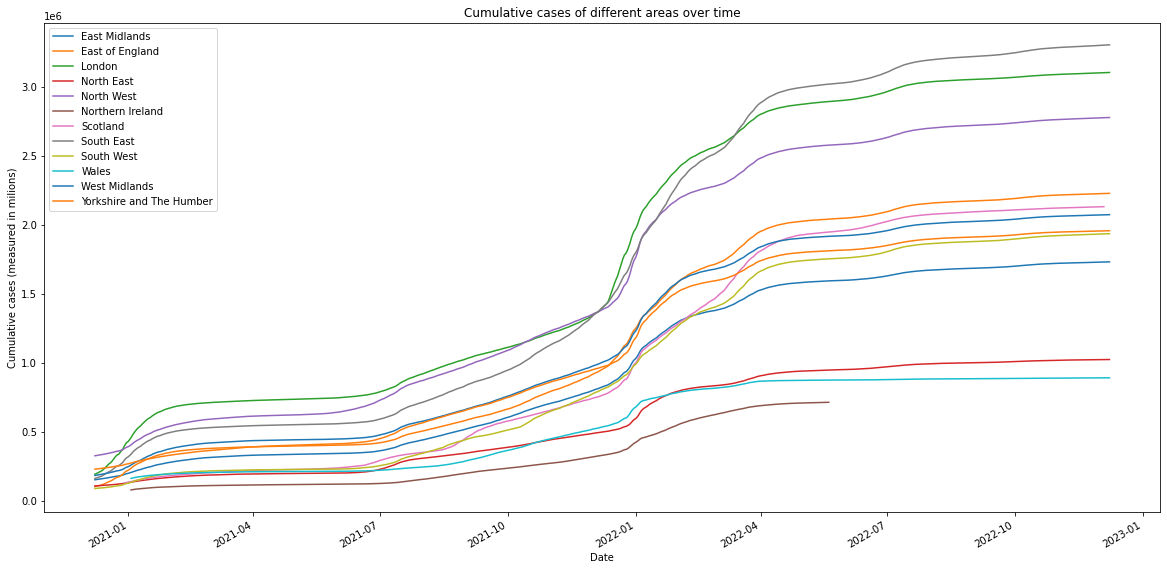

In [23]:
# Εvolution of cumulative cases of different areas over time.
# Dataset needed: covid_data

# 1. Aggregate the data 
cummulative_cases_per_area = covid_data[['date','area','cumulative_cases']]  # Keep the variables that we need 
cummulative_cases_per_area.set_index('date', inplace=True)  # Set date as the index 

# 2. Plot the data 
cummulative_cases_per_area.groupby('area')['cumulative_cases'].plot(legend=True, figsize=(20, 10), title='Cumulative cases of different areas over time',xlabel='Date', ylabel="Cumulative cases (measured in milions)")

# 3. My comment for the plot

# We cannot compare the absolute values for the cumulative cases between the regions as every region has different population.
# However we can compare the pattern of each curve and their similarities.
# Therefore from the below graph we oberve that all regions had an increasing pattern until one point in time and then they started 
# to flatten. However some areas reached to this point earlier compared to others (e.g. North East -> Jan 2022).
# Apart from this area, all the other areas reach their plateau somewhere around April 2022.


In order to interpret the results of the above plot it would benefitial to look into one of the main factors which affected the number of new COVID cases: Lockdowns 

Regarding the Lockdowns 

Based on this source: https://www.walesonline.co.uk/news/uk-news/timeline-covid-19-restrictions-england-23185495

The timeline for the period that we are interested is:

- January 6, 2021    – Third national lockdown
- March 8, 2021      – Step one (A) of unlocking
- March 29, 2021     – Step one (B) of unlocking
- April 12, 2021     – Step two of unlocking
- May 17, 2021       – Step three of unlocking
- July 19, 2021      – Step four of unlocking

From the above timeline and the above graph we can see that as the measures of the lockdown became 'softer' there is an increasing pattern in the number of cummulative cases, especially after July, 2021 which is the final step of unlocking.
From this point and onwards we can see that there is a steep increase in the cummulative number of cases until roughly April 2022. The curve eventually flattened as expected given that from one point and onwards more and more people had some type of immunity either because of a vaccine or because of a past infection. 

## Cumulative deaths in London as they evolve through time.

<AxesSubplot:title={'center':'Cumulative deaths (within 28 days of a positive test by publish date) in London over time '}, xlabel='Date', ylabel='Cumulative deaths'>

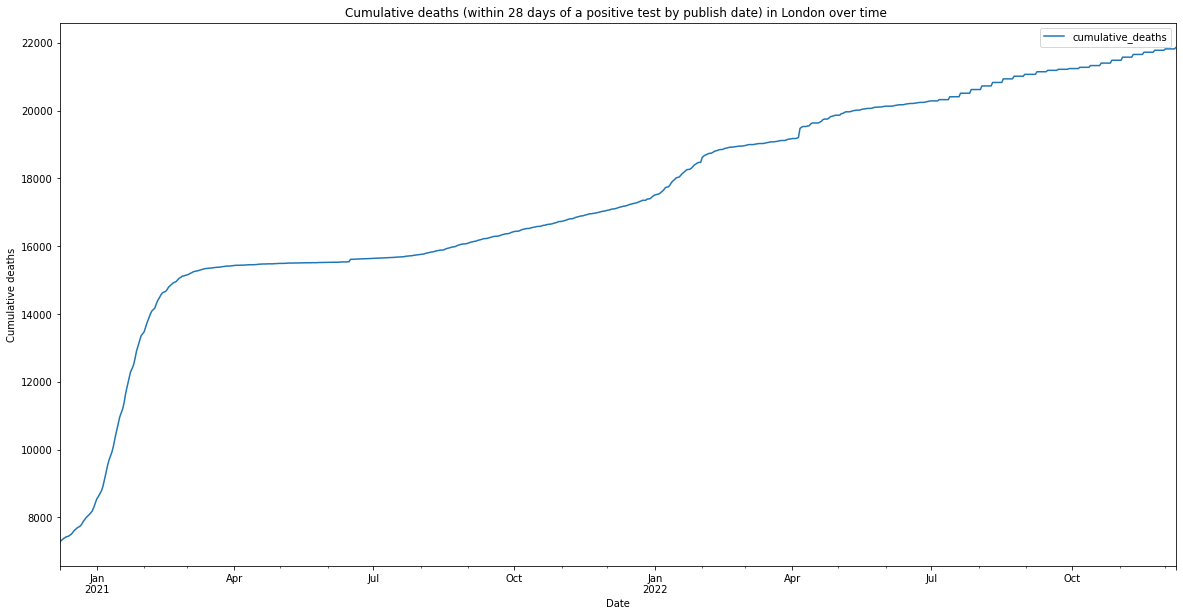

In [24]:
# Cumulative deaths in London as they evolve through time.
# Dataset needed: covid_data

# 1. Aggregate the data 

London_data = covid_data[covid_data['area'] =='London']  # Filter the rows that we are interested in.
London_data = London_data[['date','cumulative_deaths']]  # Keep the columns that we are interested in. 
London_data = London_data.set_index('date')              # Assign date column to index.

# 2. Plot the data 
London_data.plot(figsize=(20, 10), title="Cumulative deaths (within 28 days of a positive test by publish date) in London over time ",xlabel='Date', ylabel="Cumulative deaths")

# 3. My comment for the plot

# The variable cumulative_deaths measures the cumulative deaths within 28 days of a positive test by publish date.
# Based on the below graph, the slope of the curve is really steep 
# in the beggining of 2021. However after March 2021 the slope of the curve is smaller which means that less people are dying within 
# 28 days of a positive test. From this point and onwards (March 2021) the number of cumulative deaths continues to increase but at a 
# slower rate.

First we need to remind ourselves the meaning of the variables:

- cumulative_deaths: measures the cumulative deaths within 28 days of a positive test by publish date.
- cumulative_cases: measures the cumulative cases by specimen date rate

A similarity between the two plots is that after April 2022 the slopes of the curves are smaller compared to the beggining of 2021. Both of the curves have an increasing pattern but with a steeper slope in the beggining of the examined time window.

## Cumulative deaths per cases across all areas over time.

<AxesSubplot:title={'center':'cumulative deaths per cases across all areas over time '}, xlabel='Date', ylabel='cumulative deaths per cases'>

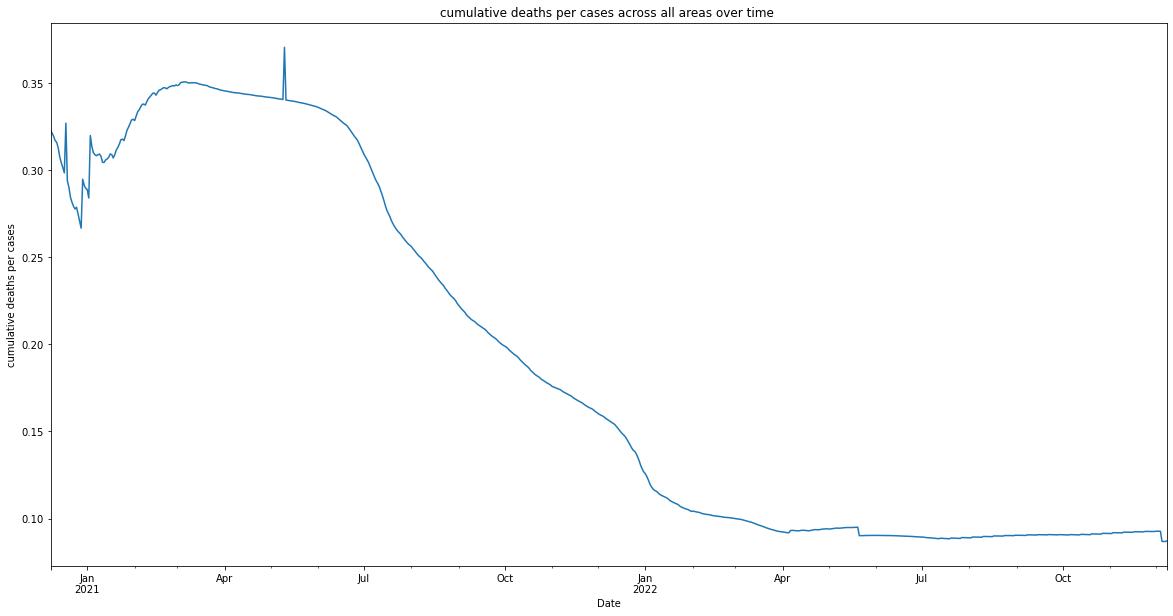

In [25]:
# 1. Aggregate the data 
df = covid_data
df['cumulative_deaths_per_cases'] = df['cumulative_deaths']/df['cumulative_cases']
# For each date we sum the cumulative_deaths_per_cases across the different areas.
df = df.groupby('date').sum()['cumulative_deaths_per_cases']

# 2. Plot the data 
df.plot(figsize=(20, 10), title="cumulative deaths per cases across all areas over time ",xlabel='Date', ylabel="cumulative deaths per cases")

# 3. My comment for the plot

# In the beggining (From January 2021 - June 2021) the ratio was prety high (roughly 30%). From June 2021 and onwards there is a huge drop on the ratio wHich means that from that point and onwards less people 
# who got covid died within 28 days of a positive test. On the whole from June 2021 until April 2022 there is a decreasing 
# pattern and then it flattens.

I believe that by June-July 2021 a big percentage of people had recieved a covid vaccine which resulted in this big drop. The increase in the percentage of people who recieved the vaccine might have affected a lot the number of people who died 
within 28 days of possitive covid test.

## Cumulative vaccinations over all areas as a function of time.

<AxesSubplot:title={'center':'Cumulative vaccinations over all areas as a function of time.'}, xlabel='Date', ylabel='Cumulative vaccinations'>

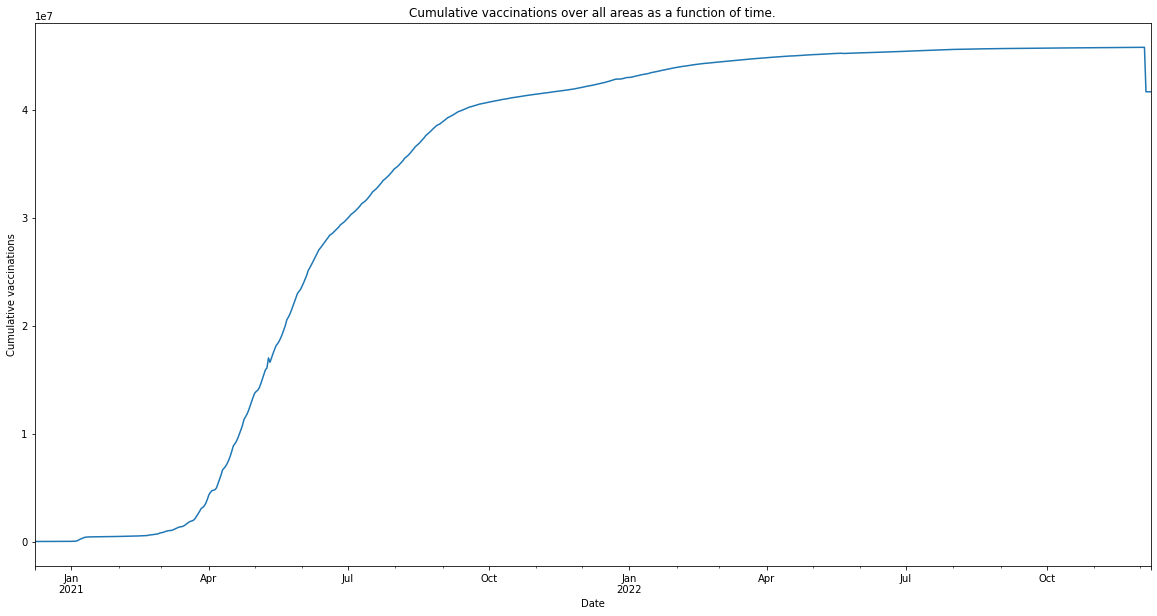

In [26]:
# 1. Aggregate the data 
# For each date we sum the number of vaccinations across the different areas.
df = covid_data.groupby('date').sum()['cumulative_vaccinated']

# 2. Plot the data 
df.plot(figsize=(20, 10), title='Cumulative vaccinations over all areas as a function of time.',xlabel='Date', ylabel="Cumulative vaccinations")

# 3. My comment for the plot 

# From the 2 plots we can see that vaccinations had indeed a big impact in the number of deaths per case. In more detail, we can see
# that during Jun-Jul 2021 we have a steep increase in the cumulative number of vaccinations and at the same time 
# based on the plot from Task 21 we can see a steep decrease in the ratio of deaths per cases. Therefore, we could say
# that vaccinations played an important role in the redutions of deaths per case. We also saw that during that time (Jun 2021)
# we had also an increase in the number of cases due to the unlocking of the lockdown. So despite the increase in the cumulative 
# number of cases the ratio of cummulative deaths per cummulative cases decreased. 

## Daily cases rolling average as a function of time, separated by areas.

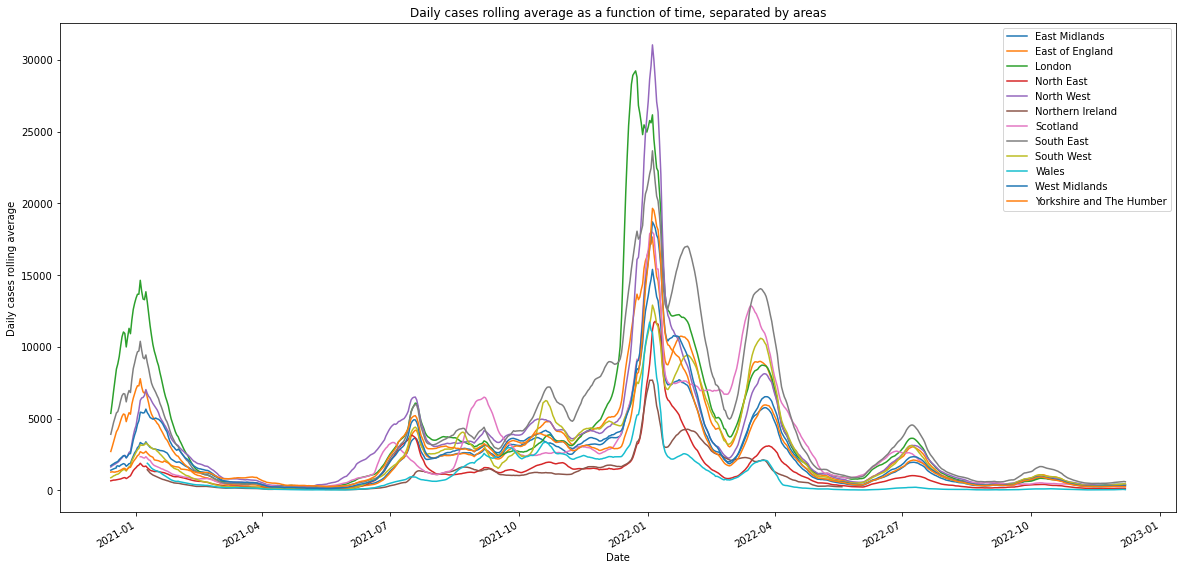

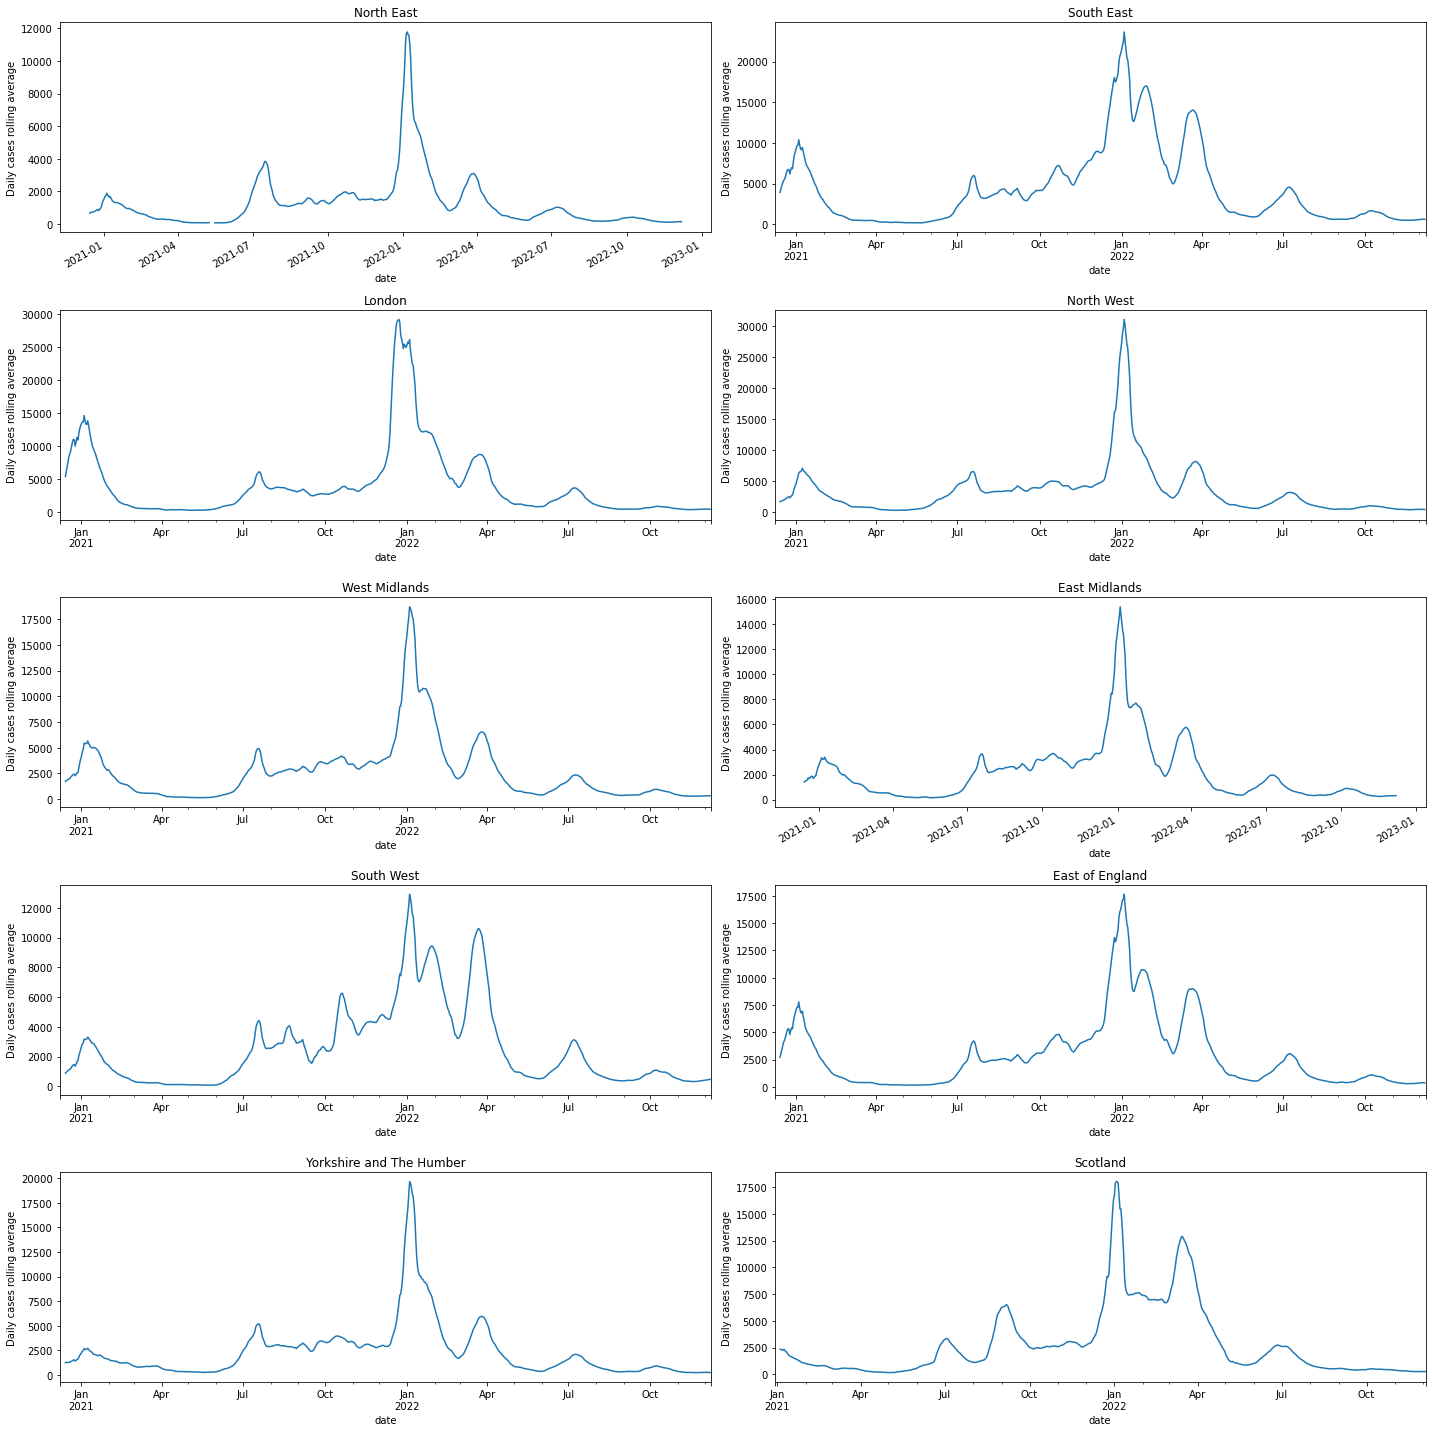

In [27]:
# Daily cases rolling average as a function of time, separated by areas.
# Dataset needed: covid_data


# 1. Aggregate the data 
df = covid_data[['date','area','daily_cases_roll_avg']]     # Keep the variables that we need 
df.set_index('date', inplace=True)                          # Set date as the index 

## Create data for individual regions 
North_east               = df[df['area']=='North East']['daily_cases_roll_avg']
South_East               = df[df['area']=='South East']['daily_cases_roll_avg']
London                   = df[df['area']=='London']['daily_cases_roll_avg']
North_West               = df[df['area']=='North West']['daily_cases_roll_avg']
West_Midlands            = df[df['area']=='West Midlands']['daily_cases_roll_avg']
East_Midlands            = df[df['area']=='East Midlands']['daily_cases_roll_avg']
South_West               = df[df['area']=='South West']['daily_cases_roll_avg']
East_of_England          = df[df['area']=='East of England']['daily_cases_roll_avg']
Yorkshire_and_The_Humber = df[df['area']=='Yorkshire and The Humber']['daily_cases_roll_avg']
Scotland                 = df[df['area']=='Scotland']['daily_cases_roll_avg']

# 2. Plot the data 
df.groupby('area')['daily_cases_roll_avg'].plot(legend=True, figsize=(20, 10), title='Daily cases rolling average as a function of time, separated by areas',xlabel='Date', ylabel="Daily cases rolling average")
plt.show()


# Plot individual plots
plt.subplot(5, 2, 1)
# plot data for North East
North_east.plot(figsize=(20, 20), title='North East', ylabel="Daily cases rolling average") 
# Plot individual plots

plt.subplot(5, 2, 2)
# plot data for South East
South_East.plot(figsize=(20, 20), title='South East', ylabel="Daily cases rolling average")

# Plot individual plots
plt.subplot(5, 2, 3)
# plot data for London
London.plot(figsize=(20, 20), title='London', ylabel="Daily cases rolling average") 

# Plot individual plots
plt.subplot(5, 2, 4)
# plot data for North West
North_West.plot(figsize=(20, 20), title='North West', ylabel="Daily cases rolling average") 

# Plot individual plots
plt.subplot(5, 2, 5)
# plot data for West Midlands
West_Midlands.plot(figsize=(20, 20), title='West Midlands', ylabel="Daily cases rolling average")

# Plot individual plots
plt.subplot(5, 2, 6)
# plot data for East Midlands
East_Midlands.plot(figsize=(20, 20), title='East Midlands', ylabel="Daily cases rolling average") 

# Plot individual plots
plt.subplot(5, 2, 7)
# plot data for South West
South_West.plot(figsize=(20, 20), title='South West', ylabel="Daily cases rolling average") 

# Plot individual plots
plt.subplot(5, 2, 8)
# plot data for East of England
East_of_England.plot(figsize=(20, 20), title='East of England', ylabel="Daily cases rolling average")

# Plot individual plots
plt.subplot(5, 2, 9)
# plot data for Yorkshire and The Humber
Yorkshire_and_The_Humber.plot(figsize=(20, 20), title='Yorkshire and The Humber', ylabel="Daily cases rolling average") 

# Plot individual plots
plt.subplot(5, 2, 10)
# plot data for Scotland
Scotland.plot(figsize=(20, 20), title='Scotland', ylabel="Daily cases rolling average")
plt.tight_layout()
plt.show()

# 3. My comment for the plot

# If we plot all the data for all the regions together we see that the results are a bit cluttered and we cannot easily
# distinquise the differences between the different regions. As a general pattern all regions seem to have some periodical peaks. 
# The biggest peaks can be seen on the following dates: January 2021, July 2021, January 2022, April 2022. 
# All the regions had the biggest peak on January 2022.
# If we plot the graphs in an individual bases side by side, it is easier to compare the patterns. So from the second plot,
# we can see that Scotland had some differences in the pattern compared to the other regions, especially from January 2022 until 
# April 2022. All the regions except Scotland witnessed some fluctuation during that period (Jan 2022-April 2022). On the 
# other hand Scotland had a flat pattern between the two peaks (from January 2022 to April 2022).
# However we should note that every region has a different population so we cannot compared their absolute values but only
# the patterns in the curves.


## Daily cases rolling average as a function of time, Scotland & South West.

area
Scotland      AxesSubplot(0.125,0.125;0.775x0.755)
South West    AxesSubplot(0.125,0.125;0.775x0.755)
Name: daily_cases_roll_avg, dtype: object

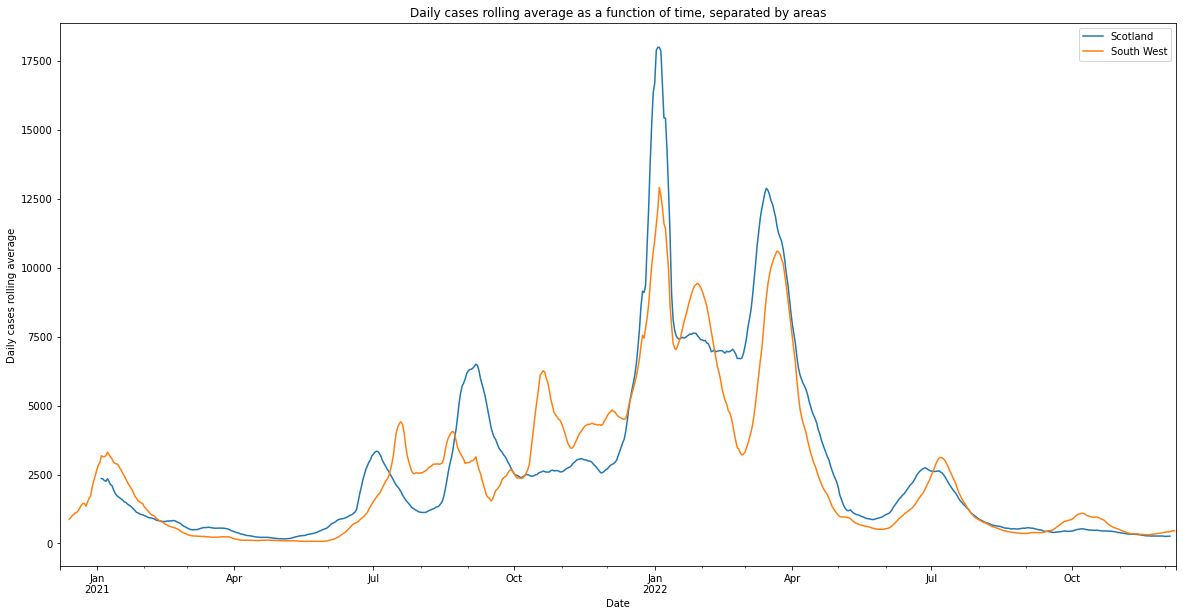

In [28]:
# Daily cases rolling average as a function of time, Scotland & South West.
# Dataset needed: covid_data

# 1. Aggregate the data 
df = covid_data[['date','area','daily_cases_roll_avg']]     # Keep the variables that we need 
df.set_index('date', inplace=True)                          # Set date as the index 
df = df[(df['area'] == 'Scotland') |(df['area'] == 'South West')]  # Keep only the data 

# 2. Plot the data 
df.groupby('area')['daily_cases_roll_avg'].plot(legend=True, figsize=(20, 10), title='Daily cases rolling average as a function of time, separated by areas',xlabel='Date', ylabel="Daily cases rolling average")

# 3. My comment for the plot 

# I believe that the main reasons for the difference in the patterns are 
# i) the geografical locations of the two regions as the one is North and the other is South
# ii) The different strategy that each region followed during the same time period.
# Regarding the difference in the absolute values this is expected due to the different populations in these two regions.


## Normalised rolling average of deaths and normalised rolling average of cases summed over all areas.

<AxesSubplot:title={'center':'normalised rolling average of deaths and normalised rolling average of cases summed over all areas'}, xlabel='date'>

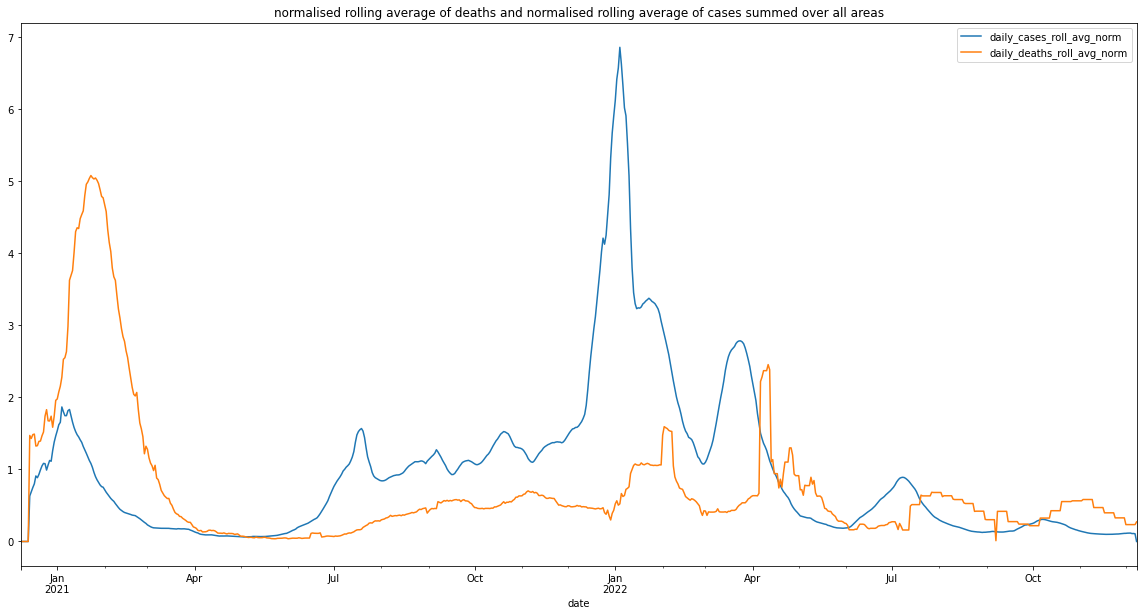

In [29]:
# Create 2 new columns: 
# daily_cases_roll_avg_norm: daily_cases_roll_avg/ max(daily_cases_roll_avg) 
# daily_deaths_roll_avg_norm: daily_deaths_roll_avg/ max(daily_deaths_roll_avg)
# dataset needed: covid_data

# 1. Aggregate the data 
# Find the maximum values 
daily_cases_rolling_max                           = covid_data['daily_cases_roll_avg'].max()
daily_deaths_rolling_max                          = covid_data['daily_deaths_roll_avg'].max()
covid_data_extended                               = covid_data
# Create the new columns 
covid_data_extended['daily_cases_roll_avg_norm']  = covid_data_extended['daily_cases_roll_avg']/daily_cases_rolling_max
covid_data_extended['daily_deaths_roll_avg_norm'] = covid_data_extended['daily_deaths_roll_avg']/daily_deaths_rolling_max

# We need to aggregate these values across all areas for the same date. Aggregation rule used is sum. 
df = covid_data_extended.groupby('date').sum()[['daily_cases_roll_avg_norm', 'daily_deaths_roll_avg_norm']]
df['date'] = df.index


# 2. Plot the data 
df.plot(x="date", y=['daily_cases_roll_avg_norm', 'daily_deaths_roll_avg_norm'], kind="line", figsize=(20, 10),title="normalised rolling average of deaths and normalised rolling average of cases summed over all areas")

# 3. My comment for the plot 

# We observe that the two plots are increasing and decreasing at the same time having a small 'delay' between them which is expected 
# given that deaths usually follow a positive case. The can be seen in all dates where we have a peak (e.g. in Jan 2021, Jan 2022). 
# If we take for example the January 2021, we can see that the normalized daily cases reach a peak and then after a few days 
# deaths reach a peak as well. This makes sense and it is similar to what we saw during covid when deaths started increasing
# 7 to 14 days after periods of increased positive cases.


## Percentage of people (in London) by demographic group who took their first dose of vaccination across time.

<AxesSubplot:title={'center':'Percentage of people (in London) by demographic group who took their first dose of vaccination across time'}, xlabel='date', ylabel='Percentage'>

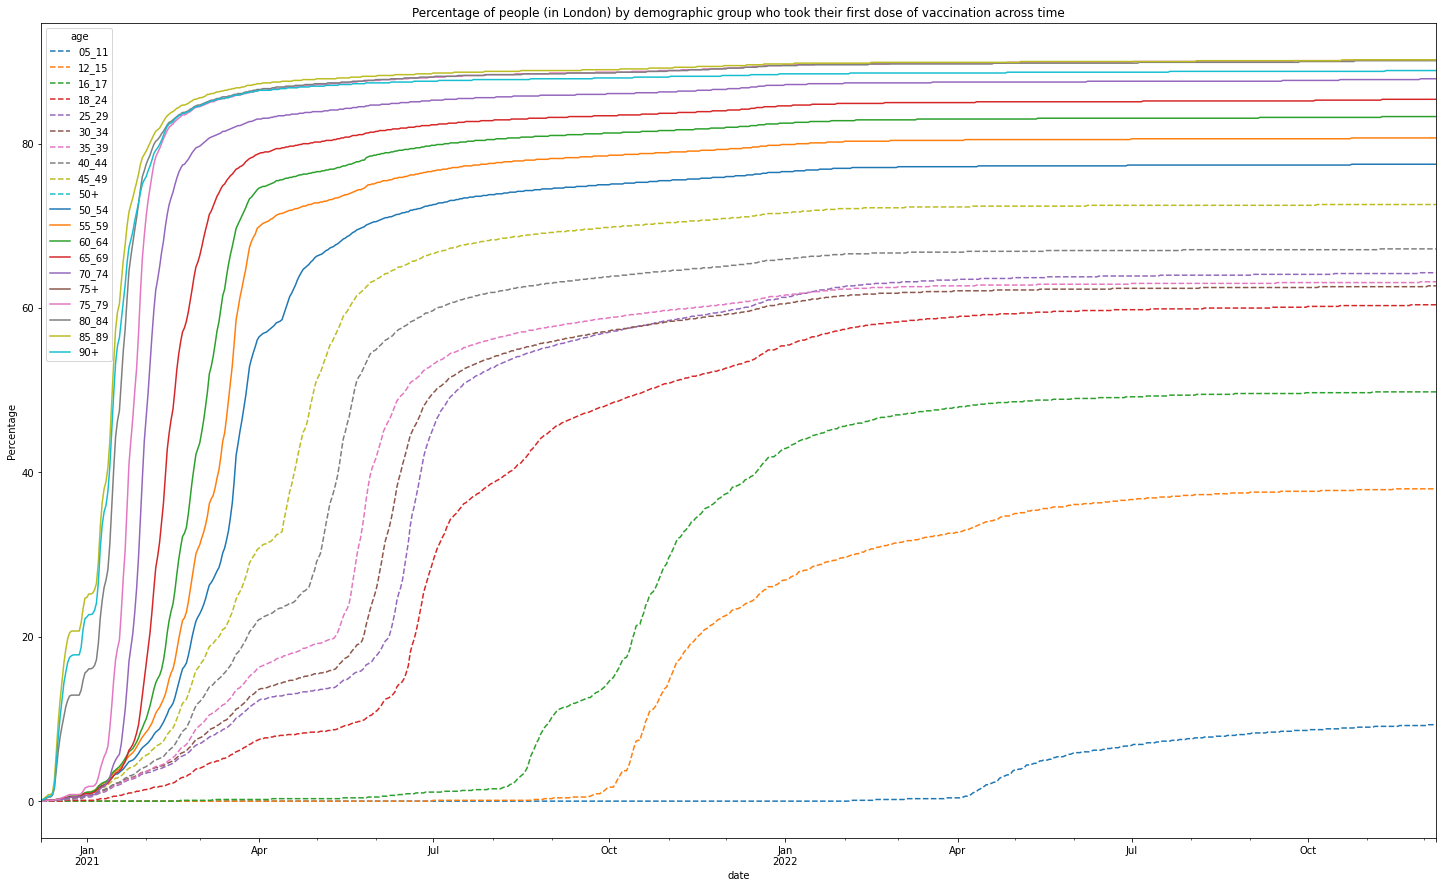

In [30]:
# dataset needed: covid_data_vaccinations_wide

# 1. Aggregate the data 

# First we keep the data for the two regions that we are interested in
London_vaccinations_wide   = covid_data_vaccinations_wide[covid_data_vaccinations_wide['area']=='London']
Scotland_vaccinations_wide = covid_data_vaccinations_wide[covid_data_vaccinations_wide['area']=='Scotland']

# Work with the London dataset and the variable: cumVaccinationFirstDoseUptakeByVaccinationDatePercentage
# Meaning of variable: Percentage of people out of that demographic who took their first dose of vaccination.

# First we need to aggregate our dataset so that each row corresponds a unique combination of date + age:
# For the aggregation we are going to use the average value of percentages across regions.
df = London_vaccinations_wide.groupby(['date', 'age']).mean()['cumVaccinationFirstDoseUptakeByVaccinationDatePercentage']
df = pd.DataFrame(df)
df = df.reset_index(level=1)  # Get indexes back to column values 
df = df.reset_index(level=0)  # Get indexes back to column values 

# Do the final transformation of the dataset 
df = df.pivot(index='date', columns='age', values='cumVaccinationFirstDoseUptakeByVaccinationDatePercentage')


# 2. Plot the data 
df.plot(figsize=(25, 15), ylabel='Percentage', title="Percentage of people (in London) by demographic group who took their first dose of vaccination across time",style=["--" for _ in range(10)])

# 3. My comment for the plot

# From the plot it is clear that the strategy which was followed was to give a priority for people in the age groups above 50 
# in terms of the the first dose of the vaccine. Also it can be seen that even inside the 'high risk' age group (above 50). There
# was also a priority to older people. So for example first people in the age group 65_69 got the first dose of the 
# vacine, and then they moved to people in the age group 50-54. So in general the higher the age the earlier he/she recieved
# the first dose of the vacine.


## Percentage of people (in Scotland) by demographic group who took their first dose of vaccination across time.

<AxesSubplot:title={'center':'Percentage of people (in Scotland) by demographic group who took their first dose of vaccination across time'}, xlabel='date', ylabel='Percentage'>

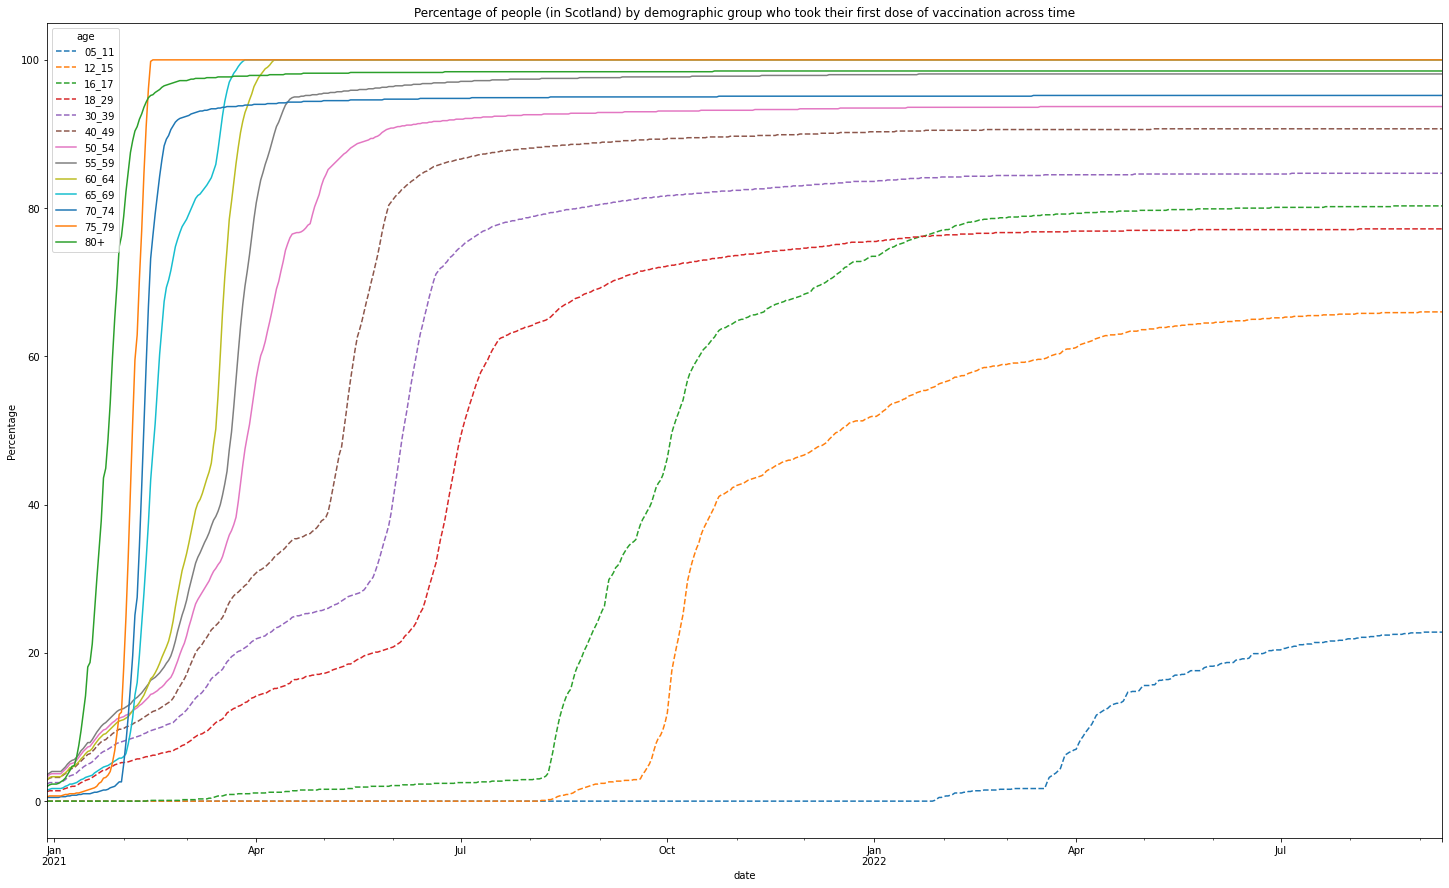

In [31]:
# 1. Aggregate the data 

# First we need to aggregate our dataset so that each row corresponds a unique combination of date + age:
# For the aggregation we are going to use the average value of percentages across regions.
df = Scotland_vaccinations_wide.groupby(['date', 'age']).mean()['cumVaccinationFirstDoseUptakeByVaccinationDatePercentage']
df = pd.DataFrame(df)
df = df.reset_index(level=1)  # Get indexes back to column values 
df = df.reset_index(level=0)  # Get indexes back to column values 

# Do the final transformation of the dataset 
df = df.pivot(index='date', columns='age', values='cumVaccinationFirstDoseUptakeByVaccinationDatePercentage')


# 2. Plot the data 
df.plot(figsize=(25, 15), ylabel='Percentage', title="Percentage of people (in Scotland) by demographic group who took their first dose of vaccination across time",style=["--" for _ in range(6)])


# 3. My comment for the plot

# We are going to compare the two age groups 50-64 & 65-79 by looking at the lower age curve for each group.
# For example for the age group 50-64 we are going to compare the age groups 50-54 between the two cities since we know that
# there was a priority in the higher ages and we expect lower bands to be vaccinated at a later point in time. 
# Also we are going to use a threshold of 70% since this is roughly the percentage 
# οf people which are needed to be vacinated in order to reach heard immunity.
# Given the above assumptions and the plots we can observe the following results:

# Age group 50-64
# Scotland reached 70% somewhere around: Mid of April 2021
# London reached 70% somewhere around: Mid-End of May 2021
# So the vaccination for this age group was faster in Scotland compared to London.

# Age group 65-79
# Scotland reached 70% somewhere around: Mid of Febrouary 2021
# London reached 70% somewhere around: First days of March 2021
# So the vaccination for this age group was faster in Scotland compared to London.

# So to sum up, the vaccination of the first dose for these two age groups seem to have been faster for Scotland
# especialy for the age group 50-64. Regarding the age group 65-79 Scotland was again faster than London but not much faster.

# In terms of total strategy I believe that in London it seems that there was a more clear priority of higher age bands
# compared to lower age groups whereas in Scotland this distinction is not so clear in the age groups above 60. 
